# Finetuning a BERT model for Classification



In [1]:
# Import the libraries
import tensorflow as tf
from transformers import __version__ as transformers_version

# Print TensorFlow and Keras version
print("TensorFlow Version:", tf.__version__)

# Print Transformers (Hugging Face BERT) version
print("Transformers Version:", transformers_version)


TensorFlow Version: 2.16.1
Transformers Version: 4.39.3


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('.data/emotions.csv')

# Drop the id column
data = data.drop('id', axis='columns')

# Display the first few rows of the dataframe
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
# Print the shape of the dataframe
print(data.shape)

# And let us count the number of unique categories
n_categories = data['label'].nunique()
print(n_categories)

(416809, 2)
6


Labels have the following meanings:

- 0: Sadness
- 1: Joy
- 2: Love
- 3: Anger
- 4: Fear
- 5: Surprise


In [4]:
# Build a dictionary of categories
categories = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Count the number of texts in each category, and convert the numerical value to a textual one
data['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [5]:
X = data['text']
y = data['label']

In [6]:
from transformers import DistilBertTokenizer

# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [7]:
import numpy as np

X_tokenized = [tokenizer(text, max_length=512, padding='max_length', truncation=True)['input_ids'] for text in X]
X_tokenized = np.array(X_tokenized)

# Show the shape of X_tokenized
print(X_tokenized.shape)

# And the first element
X_tokenized[0]

(416809, 512)


array([  101,  1045,  2074,  2514,  2428, 13346,  1998,  3082, 18627,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets, we do not use a contant random state as we want to have different splits each time we run the code

X_tokenized_train, X_tokenized_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2)

print(X_tokenized_train.shape)
print(X_tokenized_test.shape)

(333447, 512)
(83362, 512)


In [9]:
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

# Build the BERT model
foundation_model_name = 'distilbert-base-uncased'

# Configure the model, there are a number of things we will leave untouched. 
model_config = DistilBertConfig.from_pretrained(foundation_model_name, num_labels=n_categories)

#model = TFBertForSequenceClassification.from_pretrained(foundation_model_name, config=model_config)
model = TFDistilBertForSequenceClassification.from_pretrained(foundation_model_name, config=model_config)


2024-04-18 06:19:30.735531: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-18 06:19:30.735577: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-18 06:19:30.735602: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-18 06:19:30.735786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 06:19:30.735812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_

In [10]:
# This is an untrained model, so the outputs will be meaningless

sample = X_tokenized_train[0:5]
result = model(sample)

# Print the shape of the logits
print(result.logits.shape)

# Print the first element of the logits (this is a tensor with 6 elements, each corresponding to the probability of a category)
print(result.logits[0])


(5, 6)
tf.Tensor([-0.02515527 -0.06060845  0.01946818  0.02635222 -0.02984149  0.16193739], shape=(6,), dtype=float32)


In [11]:
import tensorflow as tf

batch_size = 32
epochs = 1

checkpoint_path = '.data/bert-emotions.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq=batch_size, # Save after every batch
    mode='max', # Save the model that maximizes the monitored quantity
    monitor='accuracy')

# Now let us train the model, we are going for a faster learning rate than the usual 5e-5 for BERT models
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=8e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
]
model.compile(optimizer = optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)               

In [12]:
# Load the latest checkpoint weights, if available
try:
    model.load_weights(checkpoint_path)
    print("Loaded checkpoint weights, continuing training...")
except Exception as e:
    print("Failed to load checkpoint weights, starting anew: ", e)

Loaded checkpoint weights, continuing training...


In [13]:
# Randomly sample 5 elements from X_tokenized_train without replacement
random_indexes = np.random.choice(len(X_tokenized_test), size=5, replace=False)
random_sample = X_tokenized_test[random_indexes]
result = model(random_sample)

# Show the original text, the predicted category and the actual category
for i, index in enumerate(random_indexes):
    print("Text: ", tokenizer.decode(X_tokenized_test[index]))
    print("Predicted category: ", categories[np.argmax(result.logits[i])])
    print("Actual category: ", categories[y_test.iloc[index]])
    print()

Text:  [CLS] i could feel the furious whirring of erics thoughts as he went over every aspect of my status as pythoness [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [14]:
# Run the training

# Add a callback to stop the training when the validation loss does not improve
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(
    X_tokenized_train,
    y_train,
    validation_data=(X_tokenized_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, stop_callback])


# Save the model
model.save_pretrained('.data/bert-emotions.model')

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-18 06:19:49.279812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


    7/10421 [..............................] - ETA: 49:23:00 - loss: 0.1861 - accuracy: 0.9152

2606/2606 [==============================] - 2259s 867ms/step


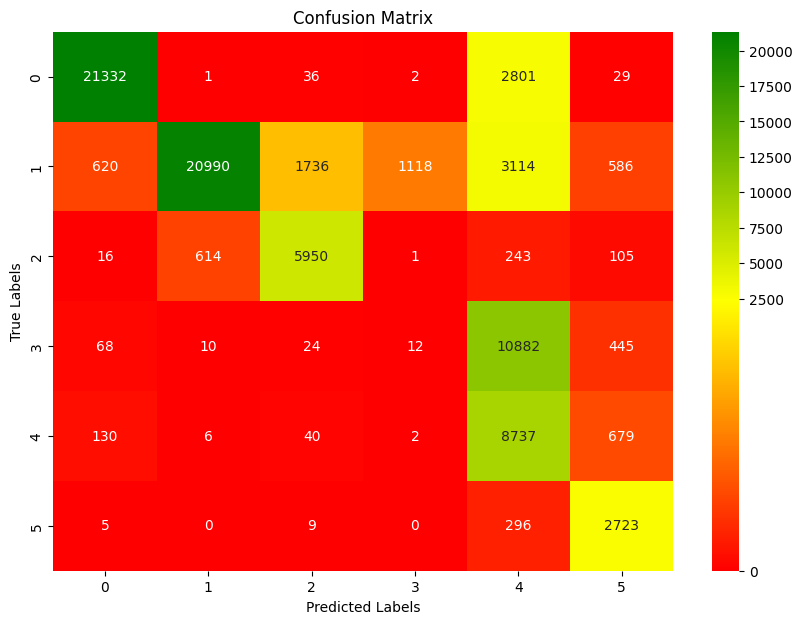

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
import matplotlib.colors as mcolors

# Get the probabilities of the categories

# Assuming your model has been trained and you have your test set ready
# Predict the probabilities on the test set
probabilities = model.predict(X_tokenized_test)

# Extract logits from the model's output
logits = probabilities.logits

# Apply softmax to logits to get probabilities
probabilities = softmax(logits, axis=1)

# Convert probabilities to predicted classes
predictions = np.argmax(probabilities, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Define a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    name='red_green_map', 
    colors=['red', 'yellow', 'green']
)

# Normalize the colormap to ensure that the diagonal (correct predictions) is green
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=np.mean(cm), vmax=np.max(cm))

# Plot the confusion matrix using Seaborn with the custom colormap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, norm=norm)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

